### https://www.kaggle.com/competitions/drawing-with-llms

In [21]:
import kagglehub
import pandas as pd

train_path = kagglehub.competition_download('drawing-with-llms', 'train.csv')
train = pd.read_csv(train_path)

train.head()

,id,description
0,04c411,a starlit night over snow-covered peaks
1,215136,black and white checkered pants
2,3e2bc6,crimson rectangles forming a chaotic grid
3,61d7a8,burgundy corduroy pants with patch pockets and...
4,6f2ca7,orange corduroy overalls


In [22]:
import openai
import pandas as pd
import time
import os
from dotenv import load_dotenv
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [23]:
# Set up OpenAI client with your API key
client = openai.OpenAI(api_key=openai_api_key)

# Function to get summary from OpenAI API
def get_rephrased(text):


    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "rephase the following context to generate a SVG image better"},
                {"role": "user", "content": text}
            ],
            temperature=0.5,
            max_tokens=1024
        )
        return response.choices[0].message.content.strip()
    
    except Exception as e:
        print(f"Error: {e}")
        return None

In [24]:
# Set up OpenAI client with your API key
client = openai.OpenAI(api_key=openai_api_key)

# Function to get summary from OpenAI API
def get_summary(text):
    instruction = f"""Generate SVG code to visually represent the following text description, while respecting the given constraints.
    
    <constraints>
    * **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
    * **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
    </constraints>

    <example>
    <description>"A red circle with a blue square inside"</description>
    ```svg
    <svg viewBox="0 0 256 256" width="256" height="256">
      <circle cx="50" cy="50" r="40" fill="red"/>
      <rect x="30" y="30" width="40" height="40" fill="blue"/>
    </svg>
    ```
    </example>

    Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints.
    Focus on a clear and concise representation of the input description within the given limitations. 
    Always provide the complete SVG code with nothing omitted. Never use an ellipsis.

    <description>"{text}"</description>
    """

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Generate an SVG code with the given instruction."},
                {"role": "user", "content": instruction}
            ],
            temperature=0.5,
            max_tokens=1024
        )
        return response.choices[0].message.content.strip()
    
    except Exception as e:
        print(f"Error: {e}")
        return None


In [25]:
# from tqdm.auto import tqdm

# tqdm.pandas()  # Enable progress bar for pandas
# train["rephrased"] = train["description"].progress_apply(get_rephrased)

In [26]:
train["svg_code"] = train["description"].progress_apply(get_summary)

  0%|          | 0/15 [00:00<?, ?it/s]

In [27]:
#train['svg_code'] = train['svg_code'].str.replace(r"```svg\n|```", "", regex=True)

In [28]:
# Function to extract SVG code from a text string
import re
default_svg='<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>'

def extract_svg_code(text):
    svg_pattern = r'<svg.*?>.*?</svg>'
    match = re.search(svg_pattern, text, re.DOTALL)
    if match:
        return match.group(0)  # Return the SVG code
    else:
        return default_svg  # No SVG found

# Apply the function to the 'svg_code' column
train['extracted_svg'] = train['svg_code'].apply(extract_svg_code)

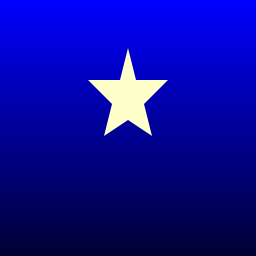

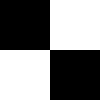

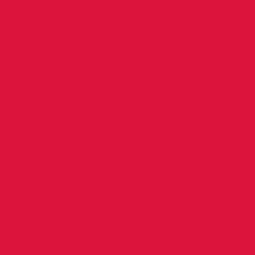

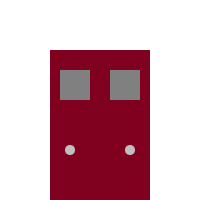

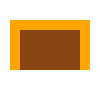

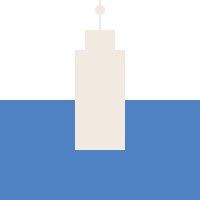

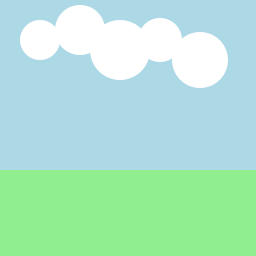

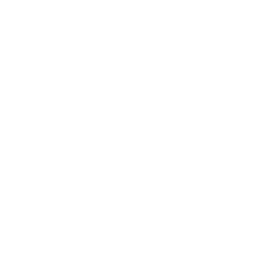

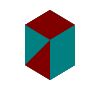

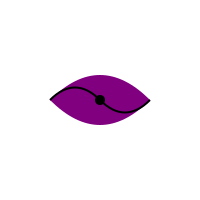

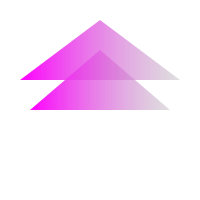

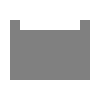

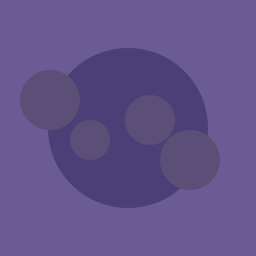

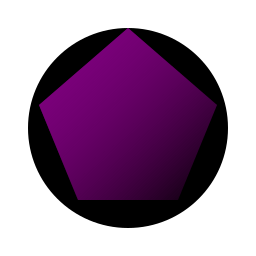

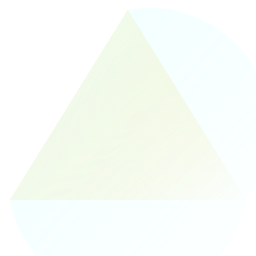

In [29]:
# We can play with our Model and render its SVG output (don't export!)
from IPython.display import SVG, display
for svg in train["extracted_svg"]:
    #print(svg)
    display(SVG(svg))

In [30]:
from transformers import AutoProcessor, AutoModel
model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384")
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")

In [31]:
import torch
from PIL import Image
import cairosvg
import os

def svgMetric(prompt, svg):
    try:
        # Convert SVG to PNG
        cairosvg.svg2png(svg, write_to="./tmp/temp.png")
        
        # Open and process the image
        image = Image.open('./tmp/temp.png').convert("RGB")
        texts = ["SVG illustration of " + prompt]
        inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")
        
        # Inference without gradient tracking
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits_per_image = outputs.logits_per_image
        probs = torch.sigmoid(logits_per_image)
        
        # Clean up temporary PNG file
        #os.remove('./tmp/temp.png')
        
        return probs[0][0].item()

    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None




In [32]:
# Using apply to process each row in the DataFrame
train['score'] = train.apply(lambda row: svgMetric(row['description'], row['extracted_svg']), axis=1)


In [33]:
# Display results
#print(train[['description', 'score']])
print('mean gpt-3.5-turbo score:',train['score'].mean())

mean gpt-3.5-turbo score: 0.10510278232207687


In [34]:
train

,id,description,svg_code,extracted_svg,score
0,04c411,a starlit night over snow-covered peaks,"```svg\n<svg viewBox=""0 0 256 256"" width=""256""...","<svg viewBox=""0 0 256 256"" width=""256"" height=...",0.005045
1,215136,black and white checkered pants,"```svg\n<svg viewBox=""0 0 100 100"" width=""100""...","<svg viewBox=""0 0 100 100"" width=""100"" height=...",0.007646
2,3e2bc6,crimson rectangles forming a chaotic grid,"```svg\n<svg viewBox=""0 0 256 256"" width=""256""...","<svg viewBox=""0 0 256 256"" width=""256"" height=...",0.007120
3,61d7a8,burgundy corduroy pants with patch pockets and...,"```svg\n<svg viewBox=""0 0 200 200"" width=""200""...","<svg viewBox=""0 0 200 200"" width=""200"" height=...",0.000453
4,6f2ca7,orange corduroy overalls,"```svg\n<svg viewBox=""0 0 100 100"" width=""100""...","<svg viewBox=""0 0 100 100"" width=""100"" height=...",0.000017
5,8066ae,a lighthouse overlooking the ocean,"```svg\n<svg viewBox=""0 0 200 200"" width=""200""...","<svg viewBox=""0 0 200 200"" width=""200"" height=...",0.053586
6,828a8f,a green lagoon under a cloudy sky,"```svg\n<svg viewBox=""0 0 256 256"" width=""256""...","<svg viewBox=""0 0 256 256"" width=""256"" height=...",0.605665
7,98f11f,a snowy plain,"```svg\n<svg viewBox=""0 0 256 256"" width=""256""...","<svg viewBox=""0 0 256 256"" width=""256"" height=...",0.000411
8,9ce3c4,a maroon dodecahedron interwoven with teal thr...,"```svg\n<svg viewBox=""0 0 100 100"" width=""100""...","<svg viewBox=""0 0 100 100"" width=""100"" height=...",0.132344
9,a9ecbb,a purple silk scarf with tassel trim,"```svg\n<svg viewBox=""0 0 200 200"" width=""200""...","<svg viewBox=""0 0 200 200"" width=""200"" height=...",0.000011
